### 导入需要的库

In [1]:
from hmm import text_to_state, HMM
from match import Match
from nlputils import *
import os
import jieba

使用`text_to_state`将目标训练语料转为对应的状态文件并输出

In [2]:
text_file_path = './corpus/2021.txt'
dest_folder = './states/'
states_file_path = dest_folder + os.path.basename(text_file_path)
text_to_state(text_file_path, dest_folder)

100%|██████████| 426206/426206 [00:05<00:00, 71709.67it/s] 


将用于训练的文本语料和状态序列文件导入

In [3]:
corpus = read_corpus_or_states_for_hmm(text_file_path)
states = read_corpus_or_states_for_hmm(states_file_path)
len(corpus)

426206

使用`yield_data`产生训练语料与测试语料

In [5]:
# corpus_train, corpus_valid = yield_data(corpus)
# states_train, states_valid = yield_data(states)
train, test = yield_data(zip(corpus, states))
corpus_train, states_train = zip(*train)
corpus_test, states_test = zip(*test)

创建`HMM`模型，并使用训练语料序列和训练状态序列进行训练

In [6]:
hmm = HMM()
hmm.train(corpus_train, states_train)

使用向前算法计算语料生成的概率，此处的概率为伪概率，在`HMM`的实现中为了避免浮点数过小而消失，会在概率较小时对其进行一次放大

In [7]:
hmm.forward("今天天气真不错")

4.0399489810399215e-19

调用`tokenzie`进行分词，方法输出状态序列

分词算法是Viterbi算法实现

In [8]:
states, res = hmm.tokenize("今天的天气真不错。我有十块钱")
states, res

(['B', 'E', 'S', 'B', 'E', 'B', 'M', 'E', 'S', 'B', 'E', 'B', 'E', 'S'],
 ['今天', '的', '天气', '真不错', '。', '我有', '十块', '钱'])

In [10]:
states, res = hmm.tokenize("国家卫健委新闻发言人、宣传司副司长米锋说")
jieba_res = jieba.lcut("国家卫健委新闻发言人、宣传司副司长米锋说", cut_all=False)
res, jieba_res

(['国家', '卫健委', '新闻', '发言人', '、', '宣传司', '副', '司长', '米锋', '说'],
 ['国家', '卫健委', '新闻', '发言人', '、', '宣传司', '副司长', '米锋', '说'])

以`jieba`的分词结果作为标准结果，在测试集上计算PRF值，并保存`HMM`的分词结果。

In [11]:
hmm_res = []
jieba_res = []
output_folder = './results/'
f = open(os.path.join(output_folder, 'hmm_result.txt'), 'w', encoding='utf-8')
for test in tqdm(corpus_test):
    test = test.replace(" ", "")
    states, hmm_tokens = hmm.tokenize(test)
    jieba_tokens = jieba.lcut(test, cut_all=False)

    # 写入
    for token in hmm_tokens:
        if token != hmm_tokens[-1]:
            f.write(token + ' ')
        else:
            f.write(token + '\n')
            
    hmm_res += hmm_tokens
    jieba_res += jieba_tokens
f.close()


In [12]:
real, pred, correct = cal_count(jieba_res, hmm_res)
p, r, f = cal_prf(real, pred, correct)
p, r, f

(0.815480534955231, 0.789920834875533, 0.8024972160880716)

##### $K$折交叉验证

定义用于k折交叉验证的函数

In [4]:
def k_fold(dataset, k=1):
    res = []
    for train_set, valid_set in k_fold_cross(dataset, k):
        corpus_train, states_train = zip(*train_set)
        corpus_valid, states_valid = zip(*valid_set)
        hmm = HMM()
        hmm.train(corpus_train, states_train)

        hmm_res = []
        jieba_res = []
        for valid in corpus_valid:
            valid = valid.replace(" ", "")
            states, hmm_tokens = hmm.tokenize(valid)
            jieba_tokens = jieba.lcut(valid, cut_all=False)
            hmm_res += hmm_tokens
            jieba_res += jieba_tokens
        real, pred, correct = cal_count(jieba_res, hmm_res)
        p, r, f = cal_prf(real, pred, correct)
        res.append((p, r, f))
        
    return res
        

进行k折交叉验证，将结果使用绘图函数画出

In [6]:
res = k_fold(zip(corpus_hmm, states_hmm), 5)

Building prefix dict from the default dictionary ...
Loading model from cache C:\WINDOWS\TEMP\jieba.cache
Loading model cost 0.441 seconds.
Prefix dict has been built successfully.


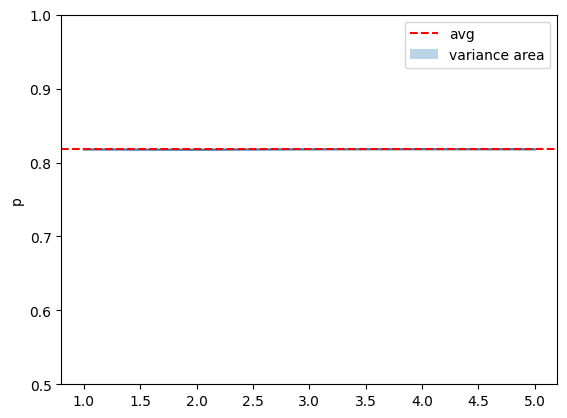

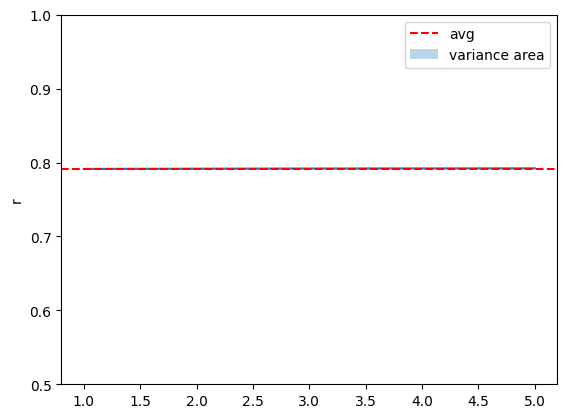

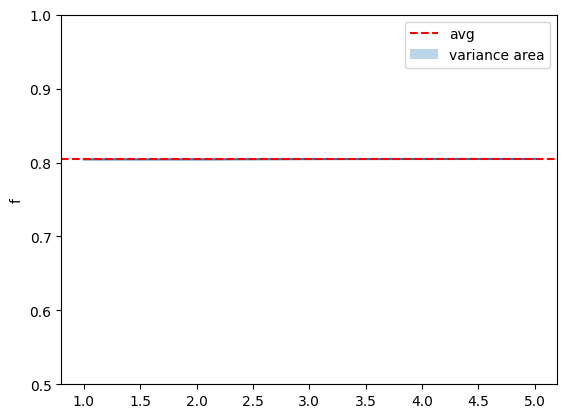

In [14]:
p, r, f = zip(*res)
show_plot(list(range(1, 6)), p, "", "P")
show_plot(list(range(1, 6)), r, "", "R")
show_plot(list(range(1, 6)), f, "", "F")

In [13]:
fold = 1
for p_, r_, f_ in zip(p, r, f):
    print(f"{fold} fold: P={p_}, R={r_}, F={f_}")
    fold += 1

1 fold: P=0.8176687105115172, R=0.7913088751037163, F=0.8042728665793901
2 fold: P=0.8173017354857717, R=0.7916019702272012, F=0.804246595720214
3 fold: P=0.8178321947733931, R=0.7918711919160559, F=0.804642346183337
4 fold: P=0.817967102006757, R=0.7920081444807656, F=0.8047783444125164
5 fold: P=0.8178391476528805, R=0.792146379732672, F=0.8047877561594247
